- Kullanacağınız veriyi indirip, okumak
- Verinizin içindeki eksik ve kategorik değişkenler ile ilgilenip modele besleyeceğimiz hale getirmek (derste gördüklerimizin üzerine de bir şeyler yapmanız hoşumuza gider demiştik, outlier'ları olan bir veride outlier'lar ile ilgili yaptıklarınızı görmek gibi şeyler olabilir mesela)
- İlgilendiğiniz probleme göre error metriğine karar vermek (derste gördüğümüz RMSE-RMSLE gibi)
- Verinizi train-validation-test diye bölmek (burada validation ve test'in gerçek hayatı yansıtması çok önemli)
- Olabildiğince fazla model denemek ve metriğimizde en iyi yapanı seçmek

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("data/EnergyEfficientDataset/ENB2012_data.csv", low_memory = False)

In [3]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


### Veriseti Hakkında Genel Bilgi

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


### Boş Sütun/Eksik Veri Kontrolü

In [5]:
df.isna().sum()

X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y1    0
Y2    0
dtype: int64

In [6]:
# Toplam Eleman sayısı
len(df)

768

### Değişkenler Arasındaki Korelasyon Analizi


In [7]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [8]:
binary_cols = [col for col in df.columns if df[col].dtype == "O" and df[col].nunique() <= 4]

In [9]:
df_label = df.copy()

In [10]:
for col in binary_cols:
    df_label = label_encoder(df_label, col).copy()

In [11]:
df_corr = df_label.corr(method ='pearson')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


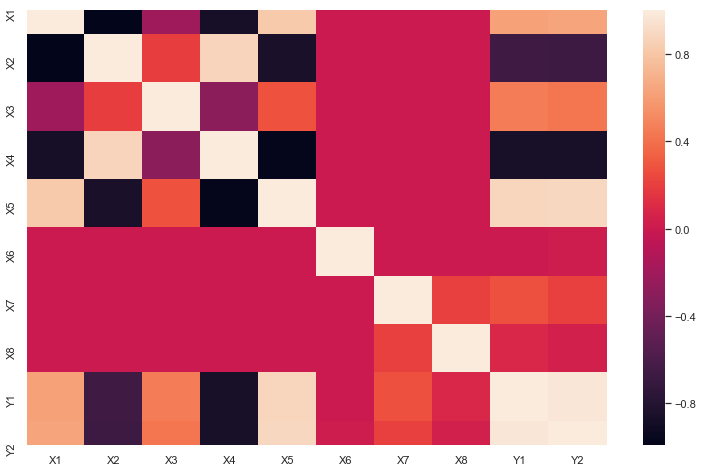

In [13]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(13,8)})
sns.heatmap(df_corr)

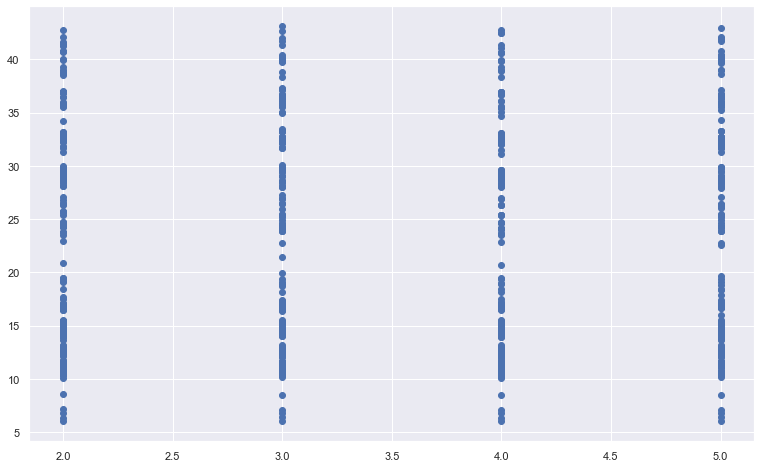

In [14]:
# Korelasyon analizi ve ikili ilişkiden görüleceği üzere X6 sütununun
# Y1 ve Y2 sütunlarına etkisi yok gibi gözüküyor.
fig, ax = plt.subplots()
ax.scatter(df["X6"], df["Y1"])

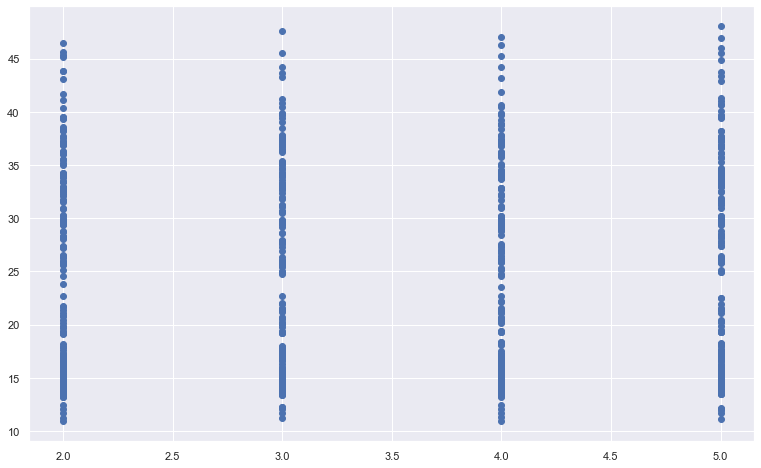

In [15]:
fig, ax = plt.subplots()
ax.scatter(df["X6"], df["Y2"])

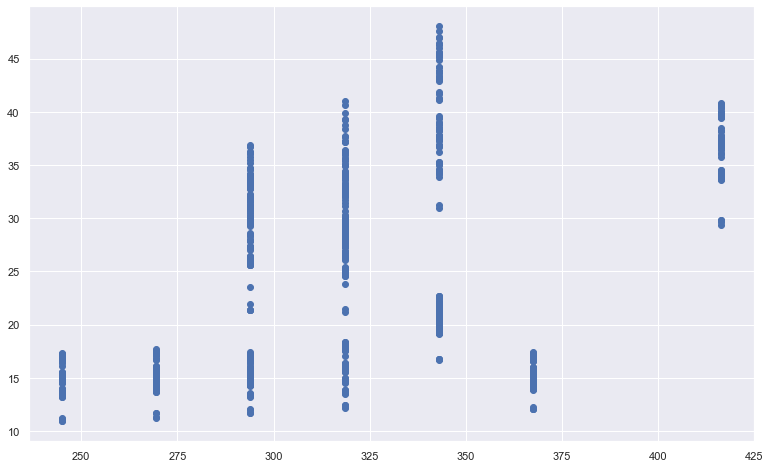

In [16]:
fig, ax = plt.subplots()
ax.scatter(df["X3"], df["Y2"])

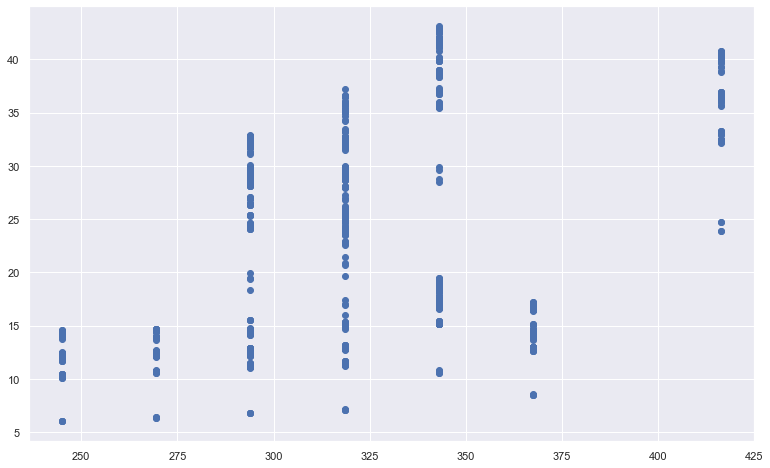

In [17]:
fig, ax = plt.subplots()
ax.scatter(df["X3"], df["Y1"])

In [18]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
    dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
    dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    return cat_cols, num_cols, cat_but_car

In [19]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [20]:
print(cat_cols, num_cols, cat_but_car)

['X3', 'X4', 'X5', 'X6', 'X7', 'X8'] ['X1', 'X2', 'Y1', 'Y2'] []


In [22]:
def cat_summary(dataframe, col_name, target_col):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
    "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe),
    f"{target_col}"+"_Mean": df.groupby(col_name)[target_col].mean()}))

In [37]:
 def cat_analyser_plot(df, cat_col, target_col): # Kategorik değişkenlerin bağımlı değişkene göre dağılımını in
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    df[cat_col].value_counts().plot(kind='bar', ax=axes[0], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[0].set_title(f"{cat_col}"+" "+"Dağılımı")
    axes[0].set_xlabel(f"{cat_col}")
    axes[0].set_ylabel("Gözlem Sayısı")
    
    df.groupby(cat_col)[target_col].mean().plot(kind='bar', ax=axes[1], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[1].set_title(f"{cat_col}"+" "+" Kırılımında"+" "+f"{target_col}"+" "+ "Ortalaması")
    axes[1].set_xlabel(f"{cat_col}")
    axes[1].set_ylabel(f"{target_col}")
    plt.show()

In [38]:
cat_summary(df, "X4", "Y1")

         X4      Ratio    Y1_Mean
110.25   64   8.333333  27.646250
122.50  128  16.666667  33.646563
147.00  192  25.000000  30.905312
220.50  384  50.000000  13.338516


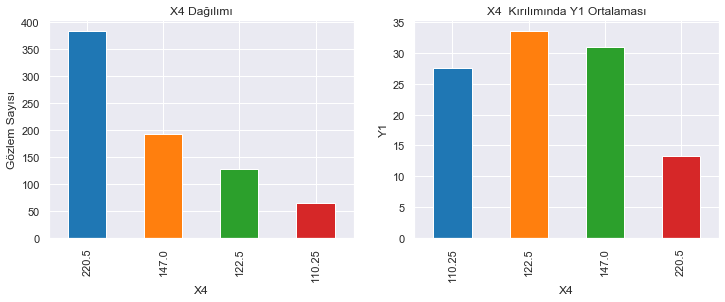

In [40]:
cat_analyser_plot(df,"X4","Y1")

In [41]:
num_cols # Nümerik değişkenler

['X1', 'X2', 'Y1', 'Y2']

In [35]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print("\t\t\t"+f"{numerical_col}"+" Nümerik Değişken İstatistikleri")
    print("\t\t\t---------------------------------------------")
    print(pd.DataFrame(dataframe[numerical_col].describe(quantiles)).T, "\n")
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

In [42]:
def num_analyser_plot(df, num_col, target_col):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    df[num_col].hist(bins=20, ax=axes[0])
    axes[0].set_title(f"{num_col}"+" "+"Dağılımı")
    axes[0].set_xlabel(f"{num_col}")
    axes[0].set_ylabel("Gözlem Sayısı")
    quantiles = [0, 0.25, 0.50, 0.75, 1]
    num_df = df.copy()
    num_df[f"{num_col}"+"_CAT"] = pd.qcut(df[num_col], q=quantiles) # nümerik değişken kategorize edildi.
    num_df.groupby(f"{num_col}"+"_CAT")[target_col].mean().plot(kind='bar', ax=axes[1], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[1].set_title(f"{num_col}"+" "+" Kırılımında"+" "+f"{target_col}"+" "+ "Ortalaması")
    axes[1].set_xlabel(f"{num_col}")
    axes[1].set_ylabel(f"{target_col}")
    plt.xticks(rotation=0)
    plt.show()

In [43]:
num_summary(df, "X1")

			X1 Nümerik Değişken İstatistikleri
			---------------------------------------------
    count      mean       std   min    5%   10%   20%   30%   40%   50%   60%  \
X1  768.0  0.764167  0.105777  0.62  0.62  0.64  0.66  0.69  0.71  0.75  0.79   

     70%   80%  90%   95%   99%   max  
X1  0.82  0.86  0.9  0.98  0.98  0.98   



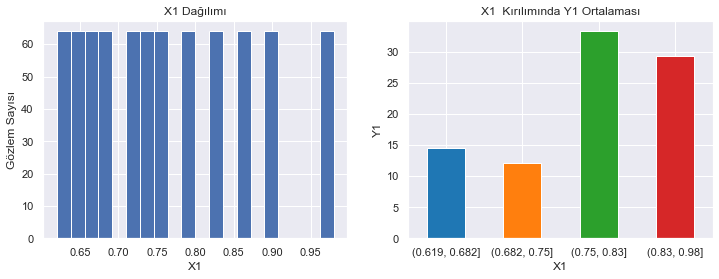

In [44]:
num_analyser_plot(df, "X1", "Y1")

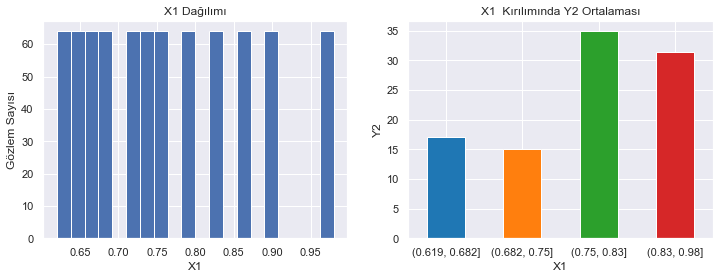

In [45]:
num_analyser_plot(df, "X1", "Y2")

## Outlier Analizi

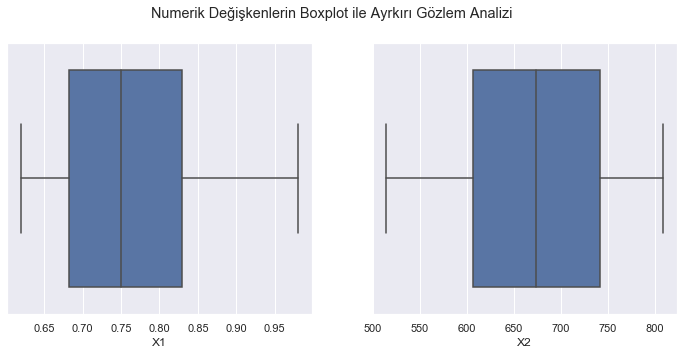

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Numerik Değişkenlerin Boxplot ile Ayrkırı Gözlem Analizi')
sns.boxplot(x=df["X1"], ax=axes[0])
sns.boxplot(x=df["X2"], ax=axes[1])
plt.show()

In [48]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [49]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [50]:
for col in num_cols:
    print(f"{col}:", check_outlier(df, col))

X1: False
X2: False
Y1: False
Y2: False


In [51]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [52]:
missing_values_table(df, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


[]

In [53]:
binary_cols

[]

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


#### Modelde herhangi bir eksik veya kategorik veri olmadığından eğitime geçebiliriz

In [55]:
# Toplam veri sayımız
len(df)

768

### Veri Setini Eğitim, Doğrulama ve Test kümelerine ayırma

In [69]:
# Verimizin üzerinde değişiklik yapmadan kopyasını aldık.
df_tmp = df.copy()

In [72]:
from sklearn.model_selection import train_test_split
y = df_tmp[["Y1", "Y2"]]

In [73]:
df_tmp = df_tmp.drop(["Y1","Y2"], axis=1)
df_tmp.head()

,X1,X2,X3,X4,X5,X6,X7,X8
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0


In [74]:
X_train, X_test, y_train, y_test = train_test_split(df_tmp, y, test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [75]:
len(X_train), len(X_valid), len(X_test)

(460, 154, 154)

In [76]:
y

,Y1,Y2
0,15.55,21.33
1,15.55,21.33
2,15.55,21.33
3,15.55,21.33
4,20.84,28.28
...,...,...
763,17.88,21.40
764,16.54,16.88
765,16.44,17.11
766,16.48,16.61


#### Değerlendirme Sonucu Oluşturma

In [77]:
# Değerlendirme fonksiyonu (RMSLE -> Root Mean Squared Logaritmic Error)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Tahmin değerleri ve olması gereken değerler arasında 
    Mean squared log error hesaplaması yapar. 
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Bir kaç farklı seviyede hata ölçen fonksiyonlar
def show_scores(model):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_valid)
    scores = {"Eğitim MAE": mean_absolute_error(y_train, train_preds),
              "Doğrulama MAE": mean_absolute_error(y_valid, test_preds),
              "Eğitim RMSLE": rmsle(y_train, train_preds),
              "Doğrulama RMSLE": rmsle(y_valid, test_preds),
              "Eğitim R^2": r2_score(y_train, train_preds),
              "Doğrulama R^2": r2_score(y_valid, test_preds)}
    return scores

#### Hiper Parametre Seçimi
Python'da bulunan RandomizedSearchCV kütüphanesi ile pek çok parametreyi veriyi iyi temsil eden bir alt küme ile deneyebilir ve bizim için en iyi sonucu veren değerler ile tüm veriyi yalnızca bir kez eğitebiliriz.

In [80]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Farklı RandomForestRegressor Parametreleri
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"]
           }

# RandomizedSearchCV modelini oluştur, 1000 iterasyonda arama yap
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=100,
                              cv=5,
                              verbose=True)

# RandomizedSearchCV modelini Eğit
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 1min 54s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [81]:
# En iyi hiper parametreleri göster
rs_model.best_params_

{'n_estimators': 50,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_features': 0.5,
 'max_depth': 10}

In [82]:
# RandomizedSearch modelini değerlendir
show_scores(rs_model)

{'Eğitim MAE': 0.7443979221795709,
 'Doğrulama MAE': 0.9065647761196252,
 'Eğitim RMSLE': 0.04135814077285869,
 'Doğrulama RMSLE': 0.04678075010890952,
 'Eğitim R^2': 0.9838476981121438,
 'Doğrulama R^2': 0.9784397489073513}

In [83]:
%%time

# Most ideal hyperparamters
ideal_model = RandomForestRegressor(n_estimators=50,
                                    min_samples_leaf=1,
                                    min_samples_split=12,
                                    max_depth = 10,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) # random state so our results are reproducible

# Fit the ideal model
ideal_model.fit(X_train, y_train)

Wall time: 139 ms


RandomForestRegressor(max_depth=10, max_features=0.5, min_samples_split=12,
                      n_estimators=50, n_jobs=-1, random_state=42)

In [84]:
# Tüm eğitim verisi ile eğitilen ideal_model için değerlendirme
show_scores(ideal_model)

{'Eğitim MAE': 0.7443979221795709,
 'Doğrulama MAE': 0.9065647761196254,
 'Eğitim RMSLE': 0.041358140772858674,
 'Doğrulama RMSLE': 0.046780750108909544,
 'Eğitim R^2': 0.9838476981121438,
 'Doğrulama R^2': 0.9784397489073513}

### Test verisi üzerinde tahmin yapma

In [85]:
test_preds = ideal_model.predict(X_test)

In [88]:
test_preds[0]

array([16.09028784, 16.56963502])

In [93]:
y_test.head(1)

,Y1,Y2
668,16.47,16.9


In [89]:
test_scores = {"Test MAE": mean_absolute_error(y_test, test_preds),
              "Test RMSLE": rmsle(y_test, test_preds),
              "Test R^2": r2_score(y_test, test_preds)}

In [90]:
test_scores

{'Test MAE': 0.8902925078413058,
 'Test RMSLE': 0.04597012703630707,
 'Test R^2': 0.9783161097739593}

### Niteliklerin (Sütunların) Önemi

In [94]:
# En iyi modelimizin özelliklerinin önemi
ideal_model.feature_importances_

array([0.21582777, 0.21192748, 0.05385967, 0.21031771, 0.23613213,
       0.00106815, 0.05397873, 0.01688837])

In [95]:
import seaborn as sns

# Özellik önemini göstermek için yardımcı fonksiyon
# Fiyata en çok etki eden 10 özelliği göstermek
def plot_features(columns, importances, n=10):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

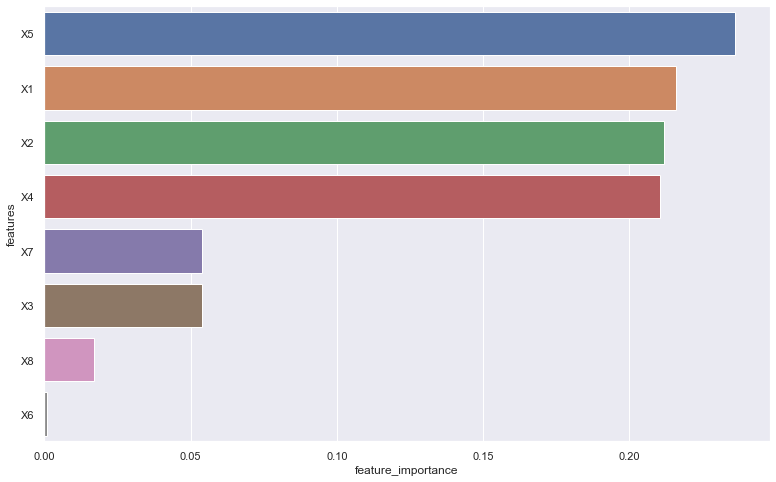

In [96]:
plot_features(X_train.columns, ideal_model.feature_importances_)

- Görüldüğü gibi baştaki korelasyon analizinde bulduğumuz X6 özelliğinin etkisiz oluşunu burada da ispatlamış olduk.
- X6 değerini tüm işlemlerin başında verimizden çıkarıp eğitimi gerçekleştirebilirdik, sonuca neredeyse hiç etkisi olmayacaktı.

In [97]:
# Tüm özelliklerimizin etkileri toplamı 1 olmalı
sum(ideal_model.feature_importances_)

1.0000000000000002